In [1]:
import os
from time import sleep
import numpy as np

In [5]:
ip = "35.227.95.194"
token = "3b6cfa310ae1c776623e9537d2726cb2b19dc0dbb5b491fa"
file = "dataset.pt"

!wget http://{ip}:8888/notebooks/work/hungry_geese/nagiss/dataproc/dataset_017_037/{file}.zip?token={token} \
        --header='Referer: http://{ip}:8888/notebooks/work/hungry_geese/nagiss/dataproc/dataset_017_037/make_dataset.ipynb' \
        -O {file}.zip

--2021-07-24 16:03:23--  http://35.227.95.194:8888/notebooks/work/hungry_geese/nagiss/dataproc/dataset_017_037/dataset.pt.zip?token=3b6cfa310ae1c776623e9537d2726cb2b19dc0dbb5b491fa
Connecting to 35.227.95.194:8888... connected.
HTTP request sent, awaiting response... 302 Found
Location: /files/work/hungry_geese/nagiss/dataproc/dataset_017_037/dataset.pt.zip [following]
--2021-07-24 16:03:23--  http://35.227.95.194:8888/files/work/hungry_geese/nagiss/dataproc/dataset_017_037/dataset.pt.zip
Reusing existing connection to 35.227.95.194:8888.
HTTP request sent, awaiting response... 200 OK
Length: 6571721368 (6.1G) [application/zip]
Saving to: ‘dataset.pt.zip’

dataset.pt.zip      100%[===================>]   6.12G  83.1MB/s    in 73s     

2021-07-24 16:04:36 (85.4 MB/s) - ‘dataset.pt.zip’ saved [6571721368/6571721368]



In [6]:
!unzip -q dataset.pt.zip

In [10]:
dataset_file = "./dataset.pt"

In [11]:
from pprint import pprint
from typing import List
from pathlib import Path
from dataclasses import dataclass, asdict


@dataclass
class Kif:
    @dataclass
    class Step:
        step: int
        remaining_times: List[float]
        agent_positions: List[List[int]]
        food_positions: List[int]
        moves: List[int]
        values: List[List[float]]
        agent_features: List[List[int]]
        condition_features: List[int]

    format_version: str
    kif_id: str
    seed: int
    agent_information: List[str]
    steps: List[Step]
    ranks: List[int]

    def kaggle_env_steps(self):
        class Struct(dict):
            def __init__(self, **entries):
                entries = {k: v for k, v in entries.items() if k != "items"}
                dict.__init__(self, entries)
                self.__dict__.update(entries)

            def __setattr__(self, attr, value):
                self.__dict__[attr] = value
                self[attr] = value

        res = []
        for step in self.steps:
            agents = [Struct() for _ in range(4)]
            for i, agent in enumerate(agents):
                agent.action = "NORTH"
                agent.reward = 0
                agent.info = {}
                agent.observation = Struct(remainingOverageTime=60, index=i)
                agent.status = "ACTIVE" if len(step.agent_positions[i]) else "DONE"
            agents[0].observation.step = step.step
            agents[0].observation.geese = step.agent_positions
            agents[0].observation.food = step.food_positions
            res.append(agents)
        return res
    
    @classmethod
    def from_dict(cls, d):
        d = d.copy()
        d["steps"] = [cls.Step(**step) for step in d["steps"]]
        return Kif(**d)

    @classmethod
    def from_file(cls, filename):
        """
        Args:
            filename (str|Path): 棋譜ファイル

        Returns:

        """
        try:
            with open(filename) as f:
                format_version = f.readline().strip()
                kif_id = f.readline().strip()
                seed = int(f.readline().strip())
                agent_information = [f.readline().strip() for _ in range(4)]
                steps = []
                while True:
                    step = int(f.readline().strip())
                    remaining_times = list(map(float, f.readline().strip().split()))
                    agent_positions = []
                    for _ in range(4):
                        _, *positions = map(int, f.readline().strip().split())
                        agent_positions.append(positions)
                    food_positions = list(map(int, f.readline().strip().split()))
                    moves = list(map(int, f.readline().strip().split()))
                    values = [list(map(float, f.readline().strip().split())) for _ in range(4)]
                    agent_features = [list(map(int, f.readline().strip().split()))[1:] for _ in range(4)]
                    _, *condition_features = map(int, f.readline().strip().split())
                    steps.append({
                        "step": step,
                        "remaining_times": remaining_times,
                        "agent_positions": agent_positions,
                        "food_positions": food_positions,
                        "moves": moves,
                        "values": values,
                        "agent_features": agent_features,
                        "condition_features": condition_features,
                    })
                    if all(m == -100 for m in moves):
                        break
                ranks = list(map(int, f.readline().strip().split()))
                return cls.from_dict({
                    "format_version": format_version,
                    "kif_id": kif_id,
                    "seed": seed,
                    "agent_information": agent_information,
                    "steps": steps,
                    "ranks": ranks,
                })
        except Exception as e:
            print(f"file reader error! {filename}")
            print("skipped!")
            #raise e


from bisect import bisect_right

FEATURE_NAMES = """
    NEIGHBOR_UP_7,
    NEIGHBOR_DOWN_7,
    NEIGHBOR_LEFT_7,
    NEIGHBOR_RIGHT_7,
    LENGTH,
    DIFFERENCE_LENGTH_1ST,
    DIFFERENCE_LENGTH_2ND,
    DIFFERENCE_LENGTH_3RD,
    DIFFERENCE_LENGTH_4TH,
    RELATIVE_POSITION_TAIL,
    RELATIVE_POSITION_OPPONENT_HEAD,
    RELATIVE_POSITION_OPPONENT_HEAD_FROM_TAIL,
    RELATIVE_POSITION_OPPONENT_TAIL,
    RELATIVE_POSITION_FOOD,
    MOVE_HISTORY,
    RELATIVE_POSITION_TAIL_ON_PLANE_X,
    RELATIVE_POSITION_TAIL_ON_PLANE_Y,
    N_REACHABLE_POSITIONS_WITHIN_1_STEP,
    N_REACHABLE_POSITIONS_WITHIN_2_STEPS,
    N_REACHABLE_POSITIONS_WITHIN_3_STEPS,
    N_REACHABLE_POSITIONS_WITHIN_4_STEPS,
    N_REACHABLE_POSITIONS_WITHIN_5_STEPS,
    N_REACHABLE_POSITIONS_WITHIN_6_STEPS,
    N_REACHABLE_POSITIONS_WITHIN_7_STEPS,
    N_REACHABLE_POSITIONS_WITHIN_8_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_1_STEP,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_2_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_3_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_4_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_5_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_6_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_7_STEPS,
    N_OPPONENTS_SHARING_REACHABLE_POSITIONS_WITHIN_8_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_1_STEP,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_2_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_3_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_4_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_5_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_6_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_7_STEPS,
    N_EXCLUSIVELY_REACHABLE_POSITIONS_WITHIN_8_STEPS,
    N_ALIVING_GEESE,
    N_OCCUPIED_POSITIONS,
    STEP,
    END
""".replace(" ", "").replace("\n", "").split(",")


def interpret_feature(feature):
    BOUNDARY = [0,128,256,384,512,589,610,631,652,673,750,826,902,978,1054,1310,1371,1432,1438,1452,1478,1518,1572,1638,1712,1790,1794,1798,1802,1806,1810,1814,1818,1822,1828,1842,1868,1908,1962,2028,2102,2180,2183,2259,2458]
    OFFSET   = [0,128,256,384,511,599,620,641,662,673,749,825,901,977,1054,1340,1401,1432,1438,1452,1478,1518,1572,1638,1712,1790,1794,1798,1802,1806,1810,1814,1818,1822,1828,1842,1868,1908,1962,2028,2102,2178,2181,2259,]
    feature_type = bisect_right(BOUNDARY, feature) - 1
    assert 0 <= feature_type < len(OFFSET), f"feature={feature}, feature_type={feature_type}"
    feature_value = feature - OFFSET[feature_type]
    res = f"{FEATURE_NAMES[feature_type]} = {feature_value} ({bin(feature_value)})"
    return res


def test_kif_read(file="kif.kif1"):
    kif = Kif.from_file(file)
    print(asdict(kif))
    for step in kif.steps:
        print(f"# step {step.step}")
        for idx_agent, features in enumerate(step.agent_features):
            print(f"- agent {idx_agent}")
            for f in features:
                print("  -", interpret_feature(f))

In [12]:
%%writefile nn.py
from time import sleep
from copy import deepcopy
from pathlib import Path

#from tqdm import tqdm
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class EfficientDataset(torch.utils.data.Dataset):
    def __init__(self, kif_files, max_data_size=200*100000):
        """局面をテンソルにまとめて持っておくデータセット
        
        Args:
            kif_files (list[str]): 棋譜ファイル名のリスト
        """

        self.kif_files = kif_files
        self.max_data_size = max_data_size  # -> 2e7
        self.max_feature_size = 50
        
        self.agent_feature_buffer     = torch.full((self.max_data_size, 4, self.max_feature_size), -100, dtype=torch.int16)
        self.condition_feature_buffer = torch.full((self.max_data_size, 3), -100, dtype=torch.int16)
        self.target_rank_buffer       = torch.full((self.max_data_size, 4), -100, dtype=torch.int8)
        self.target_policy_buffer     = torch.full((self.max_data_size, 4, 4), -100, dtype=torch.float32)
        
        self.data_size = 0
        self.load_all_states(kif_files)
    
    def copy(self):
        new_dataset = EfficientDataset([])
        new_dataset.agent_feature_buffer[:self.data_size]     = self.agent_feature_buffer[:self.data_size]
        new_dataset.condition_feature_buffer[:self.data_size] = self.condition_feature_buffer[:self.data_size]
        new_dataset.target_rank_buffer[:self.data_size]       = self.target_rank_buffer[:self.data_size]
        new_dataset.target_policy_buffer[:self.data_size]     = self.target_policy_buffer[:self.data_size]
        new_dataset.data_size = self.data_size
        return new_dataset
    
    def load_all_states(self, kif_files):
        idx = self.data_size
        for file in tqdm(kif_files):
            kif = Kif.from_file(file)
            if kif is None:
                continue
            for step in kif.steps[:-1]:  # 最後のステップは着手が無いので除外
                agent_features = torch.nn.utils.rnn.pad_sequence(
                    [torch.tensor(feats) for feats in step.agent_features],
                    batch_first=True, padding_value=-100
                ).to(torch.int16)  # padding_value を設定すると float になるので戻す必要がある
                condition_features = torch.tensor(step.condition_features)
                target_rank = torch.tensor(kif.ranks)
                target_policy = torch.tensor(step.values, dtype=torch.float)[:, 1:]
                assert target_policy.shape == (4, 4)
                
                self.agent_feature_buffer[idx, :, :agent_features.shape[1]] = agent_features
                self.condition_feature_buffer[idx] = condition_features
                self.target_rank_buffer[idx] = target_rank
                self.target_policy_buffer[idx] = target_policy
                
                idx += 1
        
        self.data_size = idx

    def __getitem__(self, idx):
        """
        これは嘘
        
        Args:
            idx (int):
        Returns:
            torch.Tensor: agent_features     エージェント特徴 (4, length) dtype=long
            torch.Tensor: condition_features 状態特徴        (length,)   dtype=long
            torch.Tensor: target_rank        最終順位        (4,)        dtype=long
            torch.Tensor: target_policy      探索で得た方策   (4, 4)      dtype=float
        """

        return idx, self

    def __len__(self):
        return self.data_size

Overwriting nn.py


In [13]:
import torch
from nn import EfficientDataset
dataset = torch.load(dataset_file)

loading data...
len(dataset)=38215198
loaded!


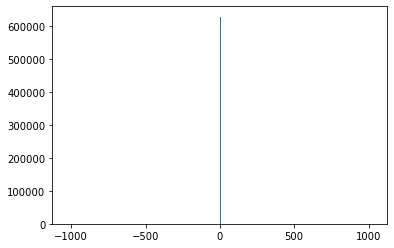

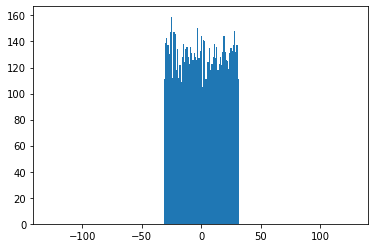

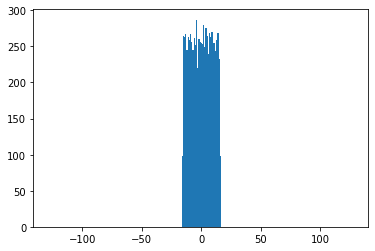

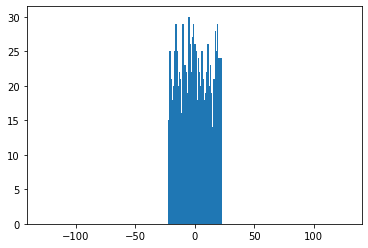

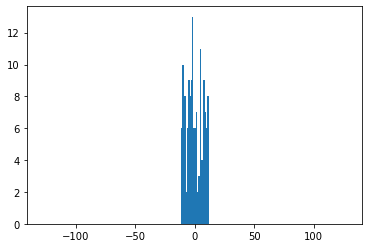

embed.weight 0.0 0.0
linear_condition.weight -31.0 31.0
linear_condition.bias 28845.0 36639.0
linear_2.weight -16.0 16.0
linear_2.bias 28769.0 36738.0
linear_3.weight -22.0 22.0
linear_3.bias 5397.0 10866.0
linear_4.weight -11.0 11.0
linear_4.bias -1408.0 1422.0
epoch 0


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7621592518690123
epoch 1


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7496815192659819
epoch 2


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7476219160148653
epoch 3


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7466340588276148
epoch 4


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7459441303044018
epoch 5


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7454193267220149
epoch 6


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7450132620259233
epoch 7


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7447072016501531
epoch 8


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7444470339182272
epoch 9


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7442214861919494


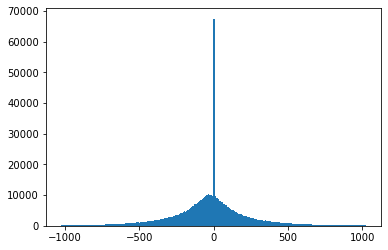

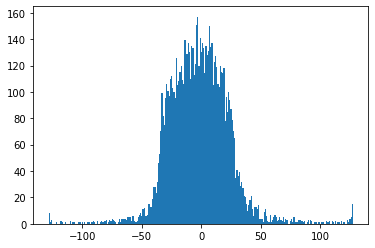

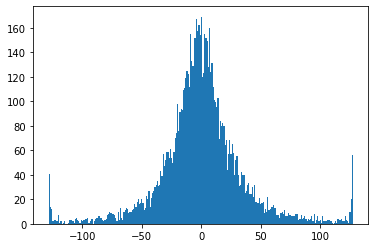

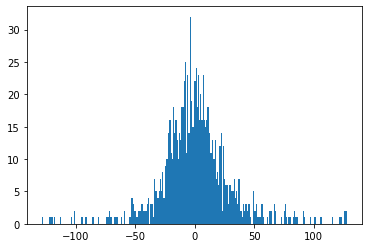

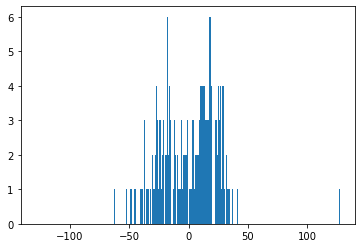

embed.weight -2051.0 2049.0
linear_condition.weight -128.0 127.0
linear_condition.bias 28270.0 35527.0
linear_2.weight -128.0 127.0
linear_2.bias 23673.0 40309.0
linear_3.weight -128.0 127.0
linear_3.bias 2150.0 13541.0
linear_4.weight -62.0 127.0
linear_4.bias -10770.0 1410.0
epoch 10


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7440088278726694
epoch 11


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7438267793465253
epoch 12


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7436743106524115
epoch 13


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7435397990698829
epoch 14


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.743419100673703
epoch 15


  0%|          | 0/9329 [00:00<?, ?it/s]

epoch_loss = 0.7433142063190653


In [14]:
from time import sleep
from copy import deepcopy
from pathlib import Path

#from tqdm import tqdm
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class Dataset(torch.utils.data.Dataset):
    def __init__(self, kif_files):
        """
        Args:
            kif_files (list[str]): 棋譜ファイル名のリスト
        """

        self.kif_files = kif_files
        self.kifs = self.load_all_kif_files(kif_files)

    def load_all_kif_files(self, kif_files):
        kifs = []  # type: List[Kif]
        for file in kif_files:
            kif = Kif.from_file(file)
            kifs.append(kif)
        return kifs

    def __getitem__(self, idx):
        """
        Args:
            idx (int):
        Returns:
            torch.Tensor: agent_features     エージェント特徴 (4, length) dtype=long
            torch.Tensor: condition_features 状態特徴        (length,)   dtype=long
            torch.Tensor: target_rank        最終順位        (4,)        dtype=long
            torch.Tensor: target_policy      探索で得た方策   (4, 4)      dtype=float
        """

        kif = self.kifs[idx]
        n_steps = len(kif.steps) - 1  # 最後のステップは着手が無いので除外
        step = torch.randint(n_steps, tuple())
        agent_features = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(feats) for feats in kif.steps[step].agent_features],
            batch_first=True, padding_value=-100
        ).to(torch.long)  # padding_value を設定すると float になるので戻す必要がある
        condition_features = torch.tensor(kif.steps[step].condition_features)
        target_rank = torch.tensor(kif.ranks)
        target_policy = torch.tensor(kif.steps[step].values, dtype=torch.float)[:, 1:]
        assert target_policy.shape == (4, 4)
        return agent_features, condition_features, target_rank, target_policy

    def __len__(self):
        return len(self.kif_files)


class FastDataset(torch.utils.data.Dataset):
    def __init__(self, kif_files):
        """局面を直接持っておくデータセット
        
        Args:
            kif_files (list[str]): 棋譜ファイル名のリスト
        """

        self.kif_files = kif_files
        self.data = self.load_all_states(kif_files)

    def load_all_states(self, kif_files):
        data = []  # type: 
        for file in tqdm(kif_files):
            kif = Kif.from_file(file)
            if kif is None:
                continue
            for step in kif.steps[:-1]:  # 最後のステップは着手が無いので除外
                agent_features = torch.nn.utils.rnn.pad_sequence(
                    [torch.tensor(feats) for feats in step.agent_features],
                    batch_first=True, padding_value=-100
                ).to(torch.long)  # padding_value を設定すると float になるので戻す必要がある
                condition_features = torch.tensor(step.condition_features)
                target_rank = torch.tensor(kif.ranks)
                target_policy = torch.tensor(step.values, dtype=torch.float)[:, 1:]
                assert target_policy.shape == (4, 4)
                data.append((agent_features, condition_features, target_rank, target_policy))
        return data

    def __getitem__(self, idx):
        """
        Args:
            idx (int):
        Returns:
            torch.Tensor: agent_features     エージェント特徴 (4, length) dtype=long
            torch.Tensor: condition_features 状態特徴        (length,)   dtype=long
            torch.Tensor: target_rank        最終順位        (4,)        dtype=long
            torch.Tensor: target_policy      探索で得た方策   (4, 4)      dtype=float
        """

        return self.data[idx]

    def __len__(self):
        return len(self.data)


class EfficientDataset(torch.utils.data.Dataset):
    def __init__(self, kif_files, max_data_size=200*100000):
        """局面をテンソルにまとめて持っておくデータセット
        
        Args:
            kif_files (list[str]): 棋譜ファイル名のリスト
        """

        self.kif_files = kif_files
        self.max_data_size = max_data_size  # -> 2e7
        self.max_feature_size = 50
        
        self.agent_feature_buffer     = torch.full((self.max_data_size, 4, self.max_feature_size), -100, dtype=torch.int16)
        self.condition_feature_buffer = torch.full((self.max_data_size, 3), -100, dtype=torch.int16)
        self.target_rank_buffer       = torch.full((self.max_data_size, 4), -100, dtype=torch.int8)
        self.target_policy_buffer     = torch.full((self.max_data_size, 4, 4), -100, dtype=torch.float32)
        
        self.data_size = 0
        self.load_all_states(kif_files)
    
    def copy(self):
        new_dataset = EfficientDataset([])
        new_dataset.agent_feature_buffer[:self.data_size]     = self.agent_feature_buffer[:self.data_size]
        new_dataset.condition_feature_buffer[:self.data_size] = self.condition_feature_buffer[:self.data_size]
        new_dataset.target_rank_buffer[:self.data_size]       = self.target_rank_buffer[:self.data_size]
        new_dataset.target_policy_buffer[:self.data_size]     = self.target_policy_buffer[:self.data_size]
        new_dataset.data_size = self.data_size
        return new_dataset
    
    def load_all_states(self, kif_files):
        idx = self.data_size
        for file in tqdm(kif_files):
            kif = Kif.from_file(file)
            if kif is None:
                continue
            for step in kif.steps[:-1]:  # 最後のステップは着手が無いので除外
                agent_features = torch.nn.utils.rnn.pad_sequence(
                    [torch.tensor(feats) for feats in step.agent_features],
                    batch_first=True, padding_value=-100
                ).to(torch.int16)  # padding_value を設定すると float になるので戻す必要がある
                condition_features = torch.tensor(step.condition_features)
                target_rank = torch.tensor(kif.ranks)
                target_policy = torch.tensor(step.values, dtype=torch.float)[:, 1:]
                assert target_policy.shape == (4, 4)
                
                self.agent_feature_buffer[idx, :, :agent_features.shape[1]] = agent_features
                self.condition_feature_buffer[idx] = condition_features
                self.target_rank_buffer[idx] = target_rank
                self.target_policy_buffer[idx] = target_policy
                
                idx += 1
        
        self.data_size = idx

    def __getitem__(self, idx):
        """
        これは嘘
        
        Args:
            idx (int):
        Returns:
            torch.Tensor: agent_features     エージェント特徴 (4, length) dtype=long
            torch.Tensor: condition_features 状態特徴        (length,)   dtype=long
            torch.Tensor: target_rank        最終順位        (4,)        dtype=long
            torch.Tensor: target_policy      探索で得た方策   (4, 4)      dtype=float
        """

        return idx, self

    def __len__(self):
        return self.data_size


class Model(nn.Module):
    def __init__(self, features, out_dim=5, hidden_1=256, hidden_2=32):
        super().__init__()
        self.features = features
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.embed = nn.EmbeddingBag(features+1, hidden_1, mode="sum", padding_idx=features)
        #self.embed.weight.data /= 16.0  # 小さめの値で初期化
        self.embed.weight.data[:] = 0.0  # 小さめの値で初期化
        self.linear_condition = nn.Linear(hidden_1, hidden_2)
        self.linear_condition.weight.data #/= 2.0
        self.linear_condition.bias.data += 0.5
        self.linear_2 = nn.Linear(hidden_1, hidden_2)
        self.linear_2.weight.data /= 2.0
        self.linear_2.bias.data += 0.5
        self.linear_3 = nn.Linear(hidden_2, hidden_2)
        self.linear_3.weight.data /= 2.0
        self.linear_3.bias.data += 0.5
        self.linear_4 = nn.Linear(hidden_2, out_dim)
        self.quantized = False

    def forward(self, x, condition, ignore_rounding=False, debug=False):
        """

        Args:
            x: [[1, 3, 9, ..., 22, -100, -100], ... ] みたいなテンソル (batch, 4, length)
            condition: (batch, length)
        Returns:
            torch.Tensor: (batch, 4, out_dim)
        """

        def hardtanh_(x, limit, p):
            if self.quantized:
                return F.hardtanh(x, -limit, limit, inplace=True)
            else:
                return F.hardtanh(x, -limit / (1 << p), limit / (1 << p), inplace=False)

        def scale(x, p):
            if self.quantized:
                if ignore_rounding:
                    return x * 2 ** p
                else:
                    return torch.round(x * 2 ** p)
            else:
                return x

        def clipped_relu(x, limit, p):
            if self.quantized:
                return F.hardtanh(x, 0.0, limit, inplace=True)
            else:
                return F.hardtanh(x, 0.0, limit / (1 << p), inplace=False)

        def add(x, a, p):
            if self.quantized:
                return x + a * (1 << p)
            else:
                return x + a
        
        batch_size = x.shape[0]
        x = torch.where(x != -100, x, self.features)

        # (1) [batch, 4, length] -> [batch, 4, 256]
        x = self.embed(x.view(batch_size * 4, -1)).view(batch_size, 4, self.hidden_1)  # scale = 2^11, max = 2^15
        x = add(x, 0.5, 11)                                    # μ=0.5, σ=1.0, min=-15.5, max=16.5 | μ=2^10, σ=2^11, min=-...
        x = clipped_relu(x, 127 << 4, 11)                      # μ=0.5, σ=1.0, min=0, max=127/128 | μ=2^10, σ=2^11, min=0, max=127<<4      # scale = 2^11, max = (2^7-1)2^4
        
        if debug:
            print(f"1) {x[0, :3, :5] / ((1<<11) if self.quantized else 1)}")

        # (2) [batch, length] -> [batch, 256]
        condition = self.embed(condition)                      # μ=0, σ=1.0, min=-16, max=16 | μ=0, σ=2^11, min=-2^15, max=2-15
        condition = add(condition, 0.5, 11)                    # μ=0.5, σ=1.0, min=-15.5, max=16.5 | μ=2^10, σ=2^11, min=...
        condition = clipped_relu(condition, 127 << 4, 11)      # μ=0.5, σ=1.0, min=0, max=127/128 | μ=2^10, σ=2^11, min=0, max=127<<5        # scale = 2^11, max = 127<<4
        condition = condition + x.sum(1)/4                     # μ=1.0, σ=2.0, min=0, max=2*127/128 | μ=2^11, σ=2^12, min=0, max=127<<5      # scale = 2^11 max = 127<<5
        if not self.quantized:
            condition *= 0.5                                   # μ=0.5, σ=1.0, min=0, max=127/128 | ...
        condition = scale(condition, -5)                       # μ=0.5, σ=1.0, min=0, max=127/128 | μ=2^6, σ=2^7, min=0, max=127            # scale = 2^7,  max = 2^7-1

        if debug:
            print(f"2) {condition[0, :20] / ((1<<7) if self.quantized else 1)}")
        
        # (3) [batch, 256] -> [batch, 32]
        condition = self.linear_condition(condition)           # scale = 2^16
        condition = clipped_relu(condition, 127 << 9, 16)      # scale = 2^16, max = (2^7-1)2^9
        #condition = scale(condition, 1)                        # scale = 2^16, max = (2^7-1)2^9
        
        if debug:
            print(f"3) {condition[0, :3] / ((1<<16) if self.quantized else 1)}")
        
        # (4) [batch, 4, 256] -> [batch, 4, 32]
        x = scale(x, -4)                                       # scale = 2^7,  max = 2^7-1
        x = self.linear_2(x)                                   # scale = 2^16
        x = clipped_relu(x, 127 << 9, 16)                      # scale = 2^16, max = (2^7-1)2^9
        x = x + condition.unsqueeze(1)                         # scale = 2^16, max = (2^7-1)2^10
        if not self.quantized:
            condition *= 0.5
        x = scale(x, -10)                                       # scale = 2^6,  max = 2^7-1

        if debug:
            print(f"4) {x[0, :3] / ((1<<6) if self.quantized else 1)}")
        
        # (5) [batch, 4, 32] -> [batch, 4, 32]
        x = self.linear_3(x)                                   # scale = 2^14
        x = clipped_relu(x, 127 << 7, 14)                      # scale = 2^14, max = (2^7-1)2^7
        x = scale(x, -7)                                       # scale = 2^7,  max = 2^7-1

        if debug:
            print(f"5) {x[0, :3] / ((1<<7) if self.quantized else 1)}")
        
        # (6) [batch, 4, 32] -> [batch, 4, out_dim]
        x = self.linear_4(x)                                   # scale = 2^13
        if self.quantized:
            x /= 1 << 13  # float に変換                        # scale = 1

        return x * 2.0

    def quantize(self, ignore_rounding=False):
        qmodel = deepcopy(self)
        qmodel.quantized = True

        # scaling
        def scale(params, p, bits=8):
            device = params.data.device
            mi = torch.tensor(-(1<<bits-1), dtype=torch.float).to(device)
            ma = torch.tensor((1<<bits-1)-1, dtype=torch.float).to(device)
            params.data = params.data * (1 << p)
            if not ignore_rounding:
                params.data = torch.round(params.data)
            params.data = torch.where(params.data > ma, ma, params.data)
            params.data = torch.where(params.data < mi, mi, params.data)
        scale(qmodel.embed.weight, 11, bits=16)
        scale(qmodel.linear_condition.weight, 9)
        scale(qmodel.linear_condition.bias, 16, bits=32)
        scale(qmodel.linear_2.weight, 9)
        scale(qmodel.linear_2.bias, 16, bits=32)
        scale(qmodel.linear_3.weight, 8)
        scale(qmodel.linear_3.bias, 14, bits=32)
        scale(qmodel.linear_4.weight, 6)
        scale(qmodel.linear_4.bias, 13, bits=32)

        return qmodel
    
    def clip_params(self, soft=False):
        def clip(params, p, bits=8):
#             device = params.data.device
#             mi = torch.tensor(-(1<<bits-1), dtype=torch.float).to(device) / (1 << p)
#             ma = torch.tensor((1<<bits-1)-1, dtype=torch.float).to(device) / (1 << p)
#             params.data = torch.where(params.data > ma, ma, params.data)
#             params.data = torch.where(params.data < mi, mi, params.data)
            mi = -(1<<bits-1) / (1 << p)
            ma = ((1<<bits-1)-1) / (1 << p)
            if soft:
                params.data = torch.tanh(params.data / ma) * ma
            else:
                params.data = F.hardtanh_(params.data, mi, ma)
        if soft:
            clip(self.embed.weight, 11, bits=11)
        else:
            clip(self.embed.weight, 11, bits=12)
        clip(self.linear_condition.weight, 9)
        clip(self.linear_condition.bias, 16, bits=32)
        clip(self.linear_2.weight, 9)
        clip(self.linear_2.bias, 16, bits=32)
        clip(self.linear_3.weight, 8)
        clip(self.linear_3.bias, 14, bits=32)
        clip(self.linear_4.weight, 6)
        clip(self.linear_4.bias, 13, bits=32)
        
    def dump(self, filename):
        assert self.quantized
        with open(filename, "wb") as f:
            def write(params, dtype="int8"):
                f.write(params.detach().numpy().ravel().astype(dtype).tobytes())
            write(self.embed.weight, "int16")
            write(self.linear_condition.weight)
            write(self.linear_condition.bias, "int32")
            write(self.linear_2.weight)
            write(self.linear_2.bias, "int32")
            write(self.linear_3.weight)
            write(self.linear_3.bias, "int32")
            write(self.linear_4.weight)
            write(self.linear_4.bias, "int32")


def soft_cross_entropy(pred, target):
    """ソフトラベルのクロスエントロピー

    全バッチの合計

    Args:
        pred: softmax 前の値 (batch, n)
        target: (batch, n)

    Returns:
        torch.Tensor: クロスエントロピー (全バッチ合計)
    """
    return -(target*F.log_softmax(pred, dim=1)).sum()


class Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, target_rank, target_policy):
        """

        Args:
            x             (torch.Tensor): モデルの出力   (batch, 4, 5) dtype=float
            target_rank   (torch.Tensor): 最終順位      (batch, 4)    dtype=long
            target_policy (torch.Tensor): 探索で得た方策 (batch, 4, 4) dtype=float
        Returns:
            torch.Tensor: loss (平均)
        """
        batch_size = x.shape[0]
        device = x.device
        
        value_loss = 0.0
        for a in range(4):
            for b in range(a+1, 4):
                rank_diff = target_rank[:, a] - target_rank[:, b]  # (batch,)
                t = torch.where(rank_diff < 0, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
                t = torch.where(rank_diff == 0, torch.tensor(0.5).to(device), t)
                pred = x[:, a, 0] - x[:, b, 0]
                value_loss = value_loss + F.binary_cross_entropy_with_logits(pred, t)
        value_loss /= 6.0  # 4C2

        pred = x[:, :, 1:].reshape(batch_size * 4, 4)
        alive = target_policy[:, :, 0] != -100.0  # (batch, 4)
        target = (target_policy*alive.unsqueeze(2)).view(batch_size*4, 4)
        policy_loss = soft_cross_entropy(pred, target) * 0.5 / (alive.sum()+1e-10)

        #print("loss:", value_loss.item(), policy_loss.item())
        loss = value_loss + policy_loss
        return loss


# def collate_fn(batch):
#     agent_features, condition_features, target_rank, target_policy = zip(*batch)
#     pad_sequence = torch.nn.utils.rnn.pad_sequence
#     agent_features = pad_sequence([f.permute(1, 0) for f in agent_features], batch_first=True,
#                                   padding_value=-100).permute(0, 2, 1).contiguous()
#     condition_features = pad_sequence(condition_features, batch_first=True, padding_value=-100).contiguous()
#     target_rank = torch.stack(target_rank)
#     target_policy = torch.stack(target_policy)
#     return agent_features, condition_features, target_rank, target_policy

def collate_fn(batch):
    idxs, (dataset, *_) = zip(*batch)
    idxs = list(idxs)
    return dataset.agent_feature_buffer[idxs].to(torch.long), dataset.condition_feature_buffer[idxs].to(torch.long), dataset.target_rank_buffer[idxs], dataset.target_policy_buffer[idxs]

def tee(text, f=None):
    print(text)
    if f is not None:
        f.write(text)
        f.write("\n")
        f.flush()

def plot_weight(model):
    qmodel = model.quantize()
    plt.hist(qmodel.embed.weight.detach().to("cpu").numpy().ravel(), bins=256, range=(-1024.5, 1023.5))
    plt.show()
    plt.hist(qmodel.linear_condition.weight.detach().to("cpu").numpy().ravel(), bins=256, range=(-128.5, 127.5))
    plt.show()
    plt.hist(qmodel.linear_2.weight.detach().to("cpu").numpy().ravel(), bins=256, range=(-128.5, 127.5))
    plt.show()
    plt.hist(qmodel.linear_3.weight.detach().to("cpu").numpy().ravel(), bins=256, range=(-128.5, 127.5))
    plt.show()
    plt.hist(qmodel.linear_4.weight.detach().to("cpu").numpy().ravel(), bins=256, range=(-128.5, 127.5))
    plt.show()
    for name, params in qmodel.named_parameters():
        print(name, params.data.to("cpu").min().numpy(), params.data.to("cpu").max().numpy())


#exit()

if __name__ == "__main__":
    # 学習

    # 設定
    #torch.set_num_threads(2)
    batch_size = 4096
    #device = "cpu"   # 2.5 it/sec (batch_size = 4096)
    #device = "cuda"  # 30 it/sec (batch_size = 4096)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_epochs = 16
    sgd_learning_rate = 1e-1
    adam_learning_rate = 1e-3
    N_FEATURES = 2458
    out_dir = Path("./out")
    #kif_files = ["kif.kif1"] * 4096  # TODO

    # 出力ディレクトリ作成
    checkpoint_dir = out_dir / "checkpoint"
    if not out_dir.exists():
        out_dir.mkdir()
        checkpoint_dir.mkdir()

    # データ
    print("loading data...")
    sleep(0.5)
    if "dataset" not in vars():
        if "dataset_file" in vars():
            dataset = torch.load(dataset_file)
        #dataset = Dataset(kif_files)
        dataset = EfficientDataset(kif_files)
    print(f"len(dataset)={len(dataset)}")
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True, num_workers=0,
        collate_fn=collate_fn, pin_memory=True, drop_last=True
    )
    print("loaded!")
    if "additional_kif_files" in vars():
        print("loading additional data...")
        dataset.load_all_states(additional_kif_files)
        print("loaded!")

    # モデル、最適化手法、損失関数
    model = Model(features=N_FEATURES)
    model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=sgd_learning_rate, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=adam_learning_rate, amsgrad=True)
    criterion = Loss()

    # 記録
    epoch_losses = []
    f_log = open(out_dir / "log.txt", "a")

    start_epoch = 0
    
    # チェックポイントの読み込み
    if "old_checkpoint_file" in vars() and Path(old_checkpoint_file).is_file():
        dict_checkpoint = torch.load(old_checkpoint_file, map_location=device)
        print("checkpoint file found!")
        start_epoch = dict_checkpoint["epoch"] + 1
        dict_checkpoint["state_dict"]["linear_4.bias"][0] = 0.0
        model.load_state_dict(dict_checkpoint["state_dict"])
        #optimizer.load_state_dict(dict_checkpoint["optimizer"])

    model.clip_params(soft=True)
    
    # 学習ループ
    for epoch in range(start_epoch, n_epochs):
        if epoch % 10 == 0:
            plot_weight(model)
        
        
        model.train()
        tee(f"epoch {epoch}", f_log)
        sleep(0.5)
        
        epoch_loss = 0.0
        n_predicted_data = 0
        iteration = 0
        for agent_features, condition_features, target_rank, target_policy in tqdm(dataloader):
            agent_features = agent_features.to(device)
            condition_features = condition_features.to(device)
            target_rank = target_rank.to(device)
            target_policy = target_policy.to(device)

            optimizer.zero_grad()
            preds = model(agent_features, condition_features)
            loss = criterion(preds, target_rank, target_policy)
            loss.backward()
            optimizer.step()
            if iteration % 5 == 0:
                model.clip_params()

            epoch_loss += loss.item() * len(agent_features)
            n_predicted_data += len(agent_features)
            iteration += 1

        epoch_loss /= n_predicted_data
        tee(f"epoch_loss = {epoch_loss}", f_log)
        epoch_losses.append(epoch_loss)

        if out_dir is not None and (epoch % 10 == 0 or epoch == n_epochs - 1):
            torch.save({
                "epoch": epoch,
                "epoch_loss": epoch_loss,
                "epoch_losses": epoch_losses,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }, checkpoint_dir / f"{epoch:03d}.pt")

    f_log.close()

In [15]:
print(torch.__config__.parallel_info())

ATen/Parallel:
	at::get_num_threads() : 2
	at::get_num_interop_threads() : 2
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 2
Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 2
Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)
std::thread::hardware_concurrency() : 4
Environment variables:
	OMP_NUM_THREADS : [not set]
	MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP



In [16]:
device = "cpu"
model = model.to("cpu")

In [17]:
agent_features, condition_features, target_rank, target_policy = next(iter(dataloader))
agent_features = agent_features.to(device)
condition_features = condition_features.to(device)
target_rank = target_rank.to(device)
target_policy = target_policy.to(device)

with torch.no_grad():
    preds = model(agent_features, condition_features, debug=True)
preds

1) tensor([[0.0000, 0.4491, 0.9922, 0.9922, 0.0000],
        [0.0000, 0.9922, 0.0000, 0.9922, 0.0000],
        [0.0000, 0.9922, 0.0000, 0.9922, 0.0000]])
2) tensor([0.0989, 0.6520, 0.1614, 0.5105, 0.0226, 0.1406, 0.6897, 0.1533, 0.2694,
        0.4640, 0.1068, 0.2758, 0.6250, 0.0438, 0.1437, 0.0413, 0.0858, 0.0000,
        0.2825, 0.1511])
3) tensor([0.0000, 0.9922, 0.0000])
4) tensor([[0.0000, 0.9922, 0.9922, 0.9922, 0.9922, 0.7798, 1.4294, 0.1595, 1.0373,
         0.4901, 0.0000, 1.5268, 0.2485, 1.8066, 0.9922, 0.9922, 0.0000, 0.0000,
         0.0504, 0.7231, 0.0000, 0.9922, 0.0000, 0.0000, 0.0000, 0.4765, 0.9922,
         0.0000, 1.5836, 0.9922, 0.3902, 0.1178],
        [0.0000, 0.9922, 0.9922, 0.7640, 0.9922, 0.2844, 0.4642, 0.0000, 1.0373,
         0.3652, 0.0000, 1.0107, 0.2419, 1.5537, 1.3778, 0.9922, 0.0000, 0.0000,
         0.0000, 0.9080, 0.0000, 0.4514, 0.0697, 0.0000, 0.0000, 0.0000, 0.9922,
         0.9511, 1.1455, 0.9922, 0.9452, 0.0722],
        [0.0000, 0.9922, 0.9922, 

tensor([[[ -3.6663,   0.8222,   0.7225,   1.8420,  -8.4835],
         [ -2.6948,   2.2246,   0.9550,  -0.2073,  -8.1117],
         [ -3.1054,   0.5536,   2.1823,   0.3198,  -8.3123],
         [ -3.0483,  -6.1629,  -3.7684,   3.3950,   3.4443]],

        [[ -3.4463,  -0.1991,  -0.9017,  -1.8029,  -1.1830],
         [ -3.1702,   1.5715,   1.8907,  -8.0500,  -0.0645],
         [ -3.0547,   0.9235,  -6.7404,   2.0195,   1.3245],
         [ -2.8161,   1.8909,   4.0779,  -4.1401,  -6.9197]],

        [[ -2.9353,  -6.7432,  -1.3340,   1.2845,   3.3612],
         [ -2.8631,   3.2019,  -4.9151,  -5.4021,   4.4582],
         [ -3.7917,   1.9206,  -0.4999,   1.6191,  -7.6171],
         [ -2.8652,   3.5274,   2.5884,  -6.0287,  -5.0679]],

        ...,

        [[-12.8188,  -0.7583,  -0.9030,  -0.7288,   0.1892],
         [ -4.1504,   3.0474,   1.7052,  -5.1434,  -4.4251],
         [ -3.1209,   0.8522,   1.3449,   0.9531,  -8.3350],
         [ -2.7288,   4.7227,  -4.0980,  -6.0579,   2.4537]],

  

In [18]:
# スケーリングのみ
smodel = model.quantize(ignore_rounding=True)
with torch.no_grad():
    spreds = smodel(agent_features, condition_features, ignore_rounding=True, debug=True)
spreds

1) tensor([[0.0000, 0.4491, 0.9922, 0.9922, 0.0000],
        [0.0000, 0.9922, 0.0000, 0.9922, 0.0000],
        [0.0000, 0.9922, 0.0000, 0.9922, 0.0000]])
2) tensor([0.0989, 0.6520, 0.1614, 0.5105, 0.0226, 0.1406, 0.6897, 0.1533, 0.2694,
        0.4640, 0.1068, 0.2758, 0.6250, 0.0438, 0.1437, 0.0413, 0.0858, 0.0000,
        0.2825, 0.1511])
3) tensor([0.0000, 0.9922, 0.0000])
4) tensor([[0.0000, 0.9922, 0.9922, 0.9922, 0.9922, 0.7798, 1.4294, 0.1595, 1.0373,
         0.4901, 0.0000, 1.5268, 0.2485, 1.8066, 0.9922, 0.9922, 0.0000, 0.0000,
         0.0504, 0.7231, 0.0000, 0.9922, 0.0000, 0.0000, 0.0000, 0.4765, 0.9922,
         0.0000, 1.5836, 0.9922, 0.3902, 0.1178],
        [0.0000, 0.9922, 0.9922, 0.7640, 0.9922, 0.2844, 0.4642, 0.0000, 1.0373,
         0.3652, 0.0000, 1.0107, 0.2419, 1.5537, 1.3778, 0.9922, 0.0000, 0.0000,
         0.0000, 0.9080, 0.0000, 0.4514, 0.0697, 0.0000, 0.0000, 0.0000, 0.9922,
         0.9511, 1.1455, 0.9922, 0.9452, 0.0722],
        [0.0000, 0.9922, 0.9922, 

tensor([[[ -3.6667,   0.8221,   0.7227,   1.8419,  -8.4836],
         [ -2.6953,   2.2245,   0.9553,  -0.2074,  -8.1117],
         [ -3.1059,   0.5534,   2.1826,   0.3197,  -8.3122],
         [ -3.0486,  -6.1634,  -3.7677,   3.3948,   3.4442]],

        [[ -3.4468,  -0.1990,  -0.9012,  -1.8036,  -1.1828],
         [ -3.1706,   1.5712,   1.8911,  -8.0501,  -0.0644],
         [ -3.0550,   0.9234,  -6.7402,   2.0191,   1.3247],
         [ -2.8164,   1.8907,   4.0781,  -4.1401,  -6.9196]],

        [[ -2.9358,  -6.7432,  -1.3336,   1.2839,   3.3613],
         [ -2.8635,   3.2017,  -4.9147,  -5.4022,   4.4582],
         [ -3.7922,   1.9203,  -0.4996,   1.6187,  -7.6166],
         [ -2.8656,   3.5273,   2.5887,  -6.0288,  -5.0679]],

        ...,

        [[-12.8189,  -0.7585,  -0.9027,  -0.7289,   0.1891],
         [ -4.1508,   3.0469,   1.7051,  -5.1434,  -4.4245],
         [ -3.1213,   0.8520,   1.3451,   0.9531,  -8.3349],
         [ -2.7293,   4.7226,  -4.0977,  -6.0580,   2.4537]],

  

In [19]:
# 量子化
qmodel = model.quantize()
with torch.no_grad():
    qpreds = qmodel(agent_features, condition_features, debug=True)
qpreds

1) tensor([[0.0000, 0.4482, 0.9922, 0.9922, 0.0000],
        [0.0000, 0.9922, 0.0000, 0.9922, 0.0000],
        [0.0000, 0.9922, 0.0000, 0.9922, 0.0000]])
2) tensor([0.1016, 0.6484, 0.1641, 0.5078, 0.0234, 0.1406, 0.6875, 0.1562, 0.2656,
        0.4609, 0.1094, 0.2734, 0.6250, 0.0469, 0.1406, 0.0391, 0.0859, 0.0000,
        0.2812, 0.1484])
3) tensor([0.0000, 0.9922, 0.0000])
4) tensor([[0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7812, 1.4375, 0.1719, 1.0312,
         0.4844, 0.0000, 1.5312, 0.2500, 1.7969, 1.0000, 1.0000, 0.0000, 0.0000,
         0.0469, 0.7344, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.4688, 1.0000,
         0.0000, 1.5781, 1.0000, 0.3906, 0.1094],
        [0.0000, 1.0000, 1.0000, 0.7656, 1.0000, 0.2812, 0.4688, 0.0000, 1.0312,
         0.3594, 0.0000, 1.0156, 0.2500, 1.5469, 1.3750, 1.0000, 0.0000, 0.0000,
         0.0000, 0.9219, 0.0000, 0.4531, 0.0625, 0.0000, 0.0000, 0.0000, 1.0000,
         0.9375, 1.1406, 1.0000, 0.9531, 0.0781],
        [0.0000, 1.0000, 1.0000, 

tensor([[[ -3.6216,   0.8586,   0.7432,   1.8059,  -8.5388],
         [ -2.6587,   2.2898,   0.9666,  -0.2319,  -8.1921],
         [ -3.0735,   0.5642,   2.1692,   0.3464,  -8.3247],
         [ -2.9790,  -6.2605,  -3.6704,   3.3655,   3.4802]],

        [[ -3.4065,  -0.2190,  -0.8630,  -1.8210,  -1.2070],
         [ -3.1418,   1.5510,   1.9082,  -8.0886,  -0.0154],
         [ -3.0037,   0.8760,  -6.7371,   2.0159,   1.3625],
         [ -2.8125,   1.9233,   4.0652,  -4.0825,  -6.9863]],

        [[ -2.8706,  -6.8330,  -1.2671,   1.2874,   3.3733],
         [ -2.8616,   3.1614,  -4.8857,  -5.4231,   4.4880],
         [ -3.7747,   1.9180,  -0.4763,   1.5942,  -7.6348],
         [ -2.8433,   3.5815,   2.6082,  -6.0210,  -5.1375]],

        ...,

        [[-12.8164,  -0.8015,  -0.8723,  -0.7886,   0.2048],
         [ -4.1353,   3.0625,   1.6858,  -5.1089,  -4.4570],
         [ -3.0605,   0.8669,   1.3694,   0.9285,  -8.3674],
         [ -2.7095,   4.7083,  -4.0562,  -6.0579,   2.4109]],

  

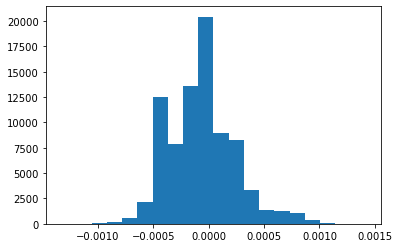

In [20]:
# スケーリング前後の差
import matplotlib.pyplot as plt
plt.hist((spreds - preds).numpy().ravel(), bins=20)
plt.show()

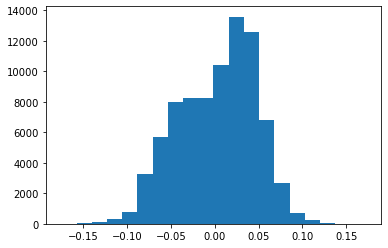

In [21]:
# 量子化前と後の差
import matplotlib.pyplot as plt
plt.hist((qpreds - spreds).numpy().ravel(), bins=20)
plt.show()

In [22]:
qmodel.state_dict()

OrderedDict([('embed.weight',
              tensor([[  413.,  -315.,   123.,  ...,    -9.,   -50.,  -156.],
                      [  497.,  -338.,  -104.,  ...,    32.,  -126.,  -212.],
                      [  447.,  -354.,  -214.,  ...,  -240.,  -193.,   -50.],
                      ...,
                      [ -136.,   982.,  1410.,  ...,   262.,  2045., -1431.],
                      [ -191., -1191.,  1420.,  ...,   478.,  1947.,  -563.],
                      [    0.,     0.,     0.,  ...,     0.,     0.,     0.]])),
             ('linear_condition.weight',
              tensor([[ -5., -24.,  -6.,  ..., -14., -12.,   6.],
                      [-40.,  25.,   4.,  ..., -29., -46., -56.],
                      [ 13.,  13.,  26.,  ...,   2.,  12., -22.],
                      ...,
                      [ 23.,  15., -31.,  ..., -32., -23.,  18.],
                      [-17., -31.,   0.,  ..., -15.,   4.,  -8.],
                      [ 18., -13., -47.,  ..., -15.,  -8., -12.]])),
     

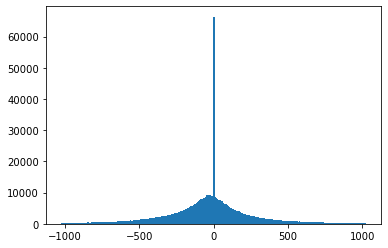

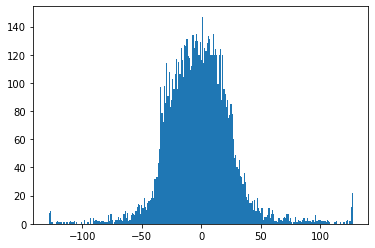

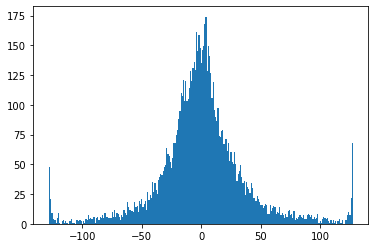

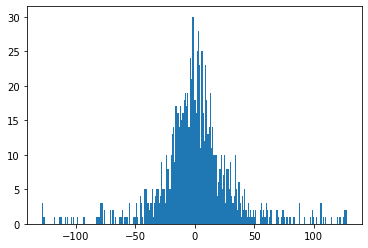

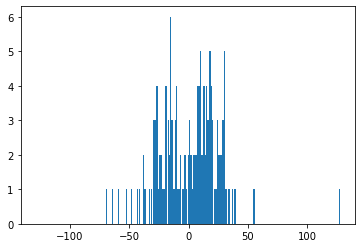

In [23]:
import matplotlib.pyplot as plt
plt.hist(qmodel.embed.weight.detach().numpy().ravel(), bins=256, range=(-1024.5, 1023.5))
plt.show()
plt.hist(qmodel.linear_condition.weight.detach().numpy().ravel(), bins=256, range=(-128.5, 127.5))
plt.show()
plt.hist(qmodel.linear_2.weight.detach().numpy().ravel(), bins=256, range=(-128.5, 127.5))
plt.show()
plt.hist(qmodel.linear_3.weight.detach().numpy().ravel(), bins=256, range=(-128.5, 127.5))
plt.show()
plt.hist(qmodel.linear_4.weight.detach().numpy().ravel(), bins=256, range=(-128.5, 127.5))
plt.show()

In [24]:
for name, params in model.named_parameters():
    print(name, params.data.min().numpy(), params.data.max().numpy())

embed.weight -1.0014892 1.0003542
linear_condition.weight -0.25000596 0.2483803
linear_condition.bias 0.4192518 0.54355484
linear_2.weight -0.25061026 0.24829414
linear_2.bias 0.32548892 0.61665
linear_3.weight -0.50017893 0.496277
linear_3.bias 0.09421888 0.8493964
linear_4.weight -1.0802807 1.9843941
linear_4.bias -2.128489 0.16439804


In [25]:
for name, params in qmodel.named_parameters():
    print(name, params.data.min().numpy(), params.data.max().numpy())

embed.weight -2051.0 2049.0
linear_condition.weight -128.0 127.0
linear_condition.bias 27476.0 35622.0
linear_2.weight -128.0 127.0
linear_2.bias 21331.0 40413.0
linear_3.weight -128.0 127.0
linear_3.bias 1544.0 13917.0
linear_4.weight -69.0 127.0
linear_4.bias -17437.0 1347.0


In [26]:
# 速度チェック

class Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, target_rank, target_policy):
        """

        Args:
            x             (torch.Tensor): モデルの出力   (batch, 4, 5) dtype=float
            target_rank   (torch.Tensor): 最終順位      (batch, 4)    dtype=long
            target_policy (torch.Tensor): 探索で得た方策 (batch, 4, 4) dtype=float
        Returns:
            torch.Tensor: loss (平均)
        """
        batch_size = x.shape[0]
        device = x.device
        
        value_loss = 0.0
        value_acc = 0.0
        for a in range(4):
            for b in range(a+1, 4):
                rank_diff = target_rank[:, a] - target_rank[:, b]  # (batch,)
                t = torch.where(rank_diff < 0, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
                t = torch.where(rank_diff == 0, torch.tensor(0.5).to(device), t)
                pred = x[:, a, 0] - x[:, b, 0]
                value_loss = value_loss + F.binary_cross_entropy_with_logits(pred, t)
                value_acc = value_acc + ((pred > 0.5) * t + (pred < 0.5) * (1-t)).mean()
        value_loss /= 6.0  # 4C2
        value_acc /= 6.0

        pred = x[:, :, 1:].reshape(batch_size * 4, 4)
        alive = target_policy[:, :, 0] != -100.0  # (batch, 4)
        target = (target_policy * alive.unsqueeze(2)).view(batch_size * 4, 4)
        policy_loss = soft_cross_entropy(pred, target) * 0.5 / (alive.sum() + 1e-10)
        
        #print(target.shape, pred.shape, alive.shape)  # torch.Size([16384, 4]) torch.Size([16384, 4]) torch.Size([4096, 4])
        policy_acc = ((target_policy.argmax(2) == x[:, :, 1:].argmax(2)) * alive).sum() / (alive.sum() + 1e-10)
        
        return value_loss, policy_loss, value_acc, policy_acc

criterion = Loss()
with torch.no_grad():
    epoch_value_loss = 0.0
    epoch_policy_loss = 0.0
    epoch_value_acc = 0.0
    epoch_policy_acc = 0.0
    n_predicted_data = 0
    for idx, (agent_features, condition_features, target_rank, target_policy) in enumerate(tqdm(dataloader)):
        if idx % 100 != 0:
            continue
        agent_features = agent_features.to(device)
        condition_features = condition_features.to(device)
        target_rank = target_rank.to(device)
        target_policy = target_policy.to(device)

        optimizer.zero_grad()
        preds = qmodel(agent_features, condition_features)
        
        v, p, va, pa = criterion(preds, target_rank, target_policy)
        epoch_value_loss += v.item() * len(agent_features)
        epoch_policy_loss += p.item() * len(agent_features)
        epoch_value_acc += va.item() * len(agent_features)
        epoch_policy_acc += pa.item() * len(agent_features)
        n_predicted_data += len(agent_features)
    epoch_value_loss /= n_predicted_data
    epoch_policy_loss /= n_predicted_data
    epoch_value_acc /= n_predicted_data
    epoch_policy_acc /= n_predicted_data
print(epoch_value_loss, epoch_policy_loss)

  0%|          | 0/9329 [00:00<?, ?it/s]

0.4363916215110332 0.3057122782189795


In [27]:
print(epoch_value_acc, epoch_policy_acc)

0.7278821151307289 0.7606947872232883


In [28]:
target_policy[:4]

tensor([[[ 7.7472e-03,  0.0000e+00,  1.4812e-03,  9.9077e-01],
         [-1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
         [ 3.4159e-06,  0.0000e+00,  3.1085e-04,  9.9969e-01],
         [-1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02]],

        [[ 7.2339e-02,  6.2029e-01,  3.0738e-01,  0.0000e+00],
         [ 0.0000e+00,  2.9132e-01,  7.0813e-01,  5.5043e-04],
         [ 0.0000e+00,  1.3021e-04,  9.9961e-01,  2.6042e-04],
         [ 1.3233e-02,  0.0000e+00,  3.3602e-02,  9.5317e-01]],

        [[ 2.2528e-04,  0.0000e+00,  2.0275e-02,  9.7950e-01],
         [-1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
         [ 3.3647e-04,  2.2432e-04,  9.9944e-01,  0.0000e+00],
         [ 1.1457e-04,  4.0445e-02,  9.5944e-01,  0.0000e+00]],

        [[ 4.9871e-02,  9.5001e-01,  1.2253e-04,  0.0000e+00],
         [-1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
         [ 9.9353e-01,  5.6159e-03,  8.5460e-04,  0.0000e+00],
         [ 3.6684e-04,  2.4456e-04,  9.9939e-01, 

In [29]:
ag, cn = agent_features[:1], condition_features[:1]
p = qmodel(ag, cn)
print(ag)
print(cn)
print(p)

tensor([[[ 112,  247,  346,  507,  534,  599,  620,  651,  672,  733,  782,
           886,  921, 1000, 1018, 1145, 1346, 1403, 1433, 1441, 1458, 1490,
          1535, 1595, 1667, 1748, 1790, 1794, 1799, 1803, 1807, 1811, 1815,
          1819, 1823, 1831, 1847, 1874, 1911, 1964, 2029, 2102, -100, -100,
          -100, -100, -100, -100, -100, -100],
         [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100],
         [  63,  129,  280,  429,  534,  599,  620,  651,  672,  737,  793,
           893,  928, 1044,  985, 1245, 1342, 1403, 1434, 1444, 1463, 1495,
          1545, 1608, 1683, 1761, 1790, 1794, 1799, 1803, 1807, 1811, 1815,
          1819, 1824, 1834, 1852, 1879, 1921, 1977, 2045, 2115, -100, 

In [30]:
qmodel.to("cpu").dump("parameters.bin")

# epoch 10

In [31]:
dict_checkpoint = torch.load("./out/checkpoint/010.pt", map_location=device)
model.load_state_dict(dict_checkpoint["state_dict"])
qmodel = model.quantize()
qmodel.to("cpu").dump("038_01_10epoch.bin")

In [32]:
!diff 038_01_10epoch.bin parameters.bin

Binary files 038_01_10epoch.bin and parameters.bin differ
